<a href="https://colab.research.google.com/github/s241002/Never-Look-for-Whats-Lost/blob/main/yolov8_%E8%A9%A6%E4%BD%9C%E5%93%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00



image 1/1 /content/メディア (1).jpg: 640x640 2 laptops, 1 mouse, 1 keyboard, 1 cell phone, 367.9ms
Speed: 10.0ms preprocess, 367.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


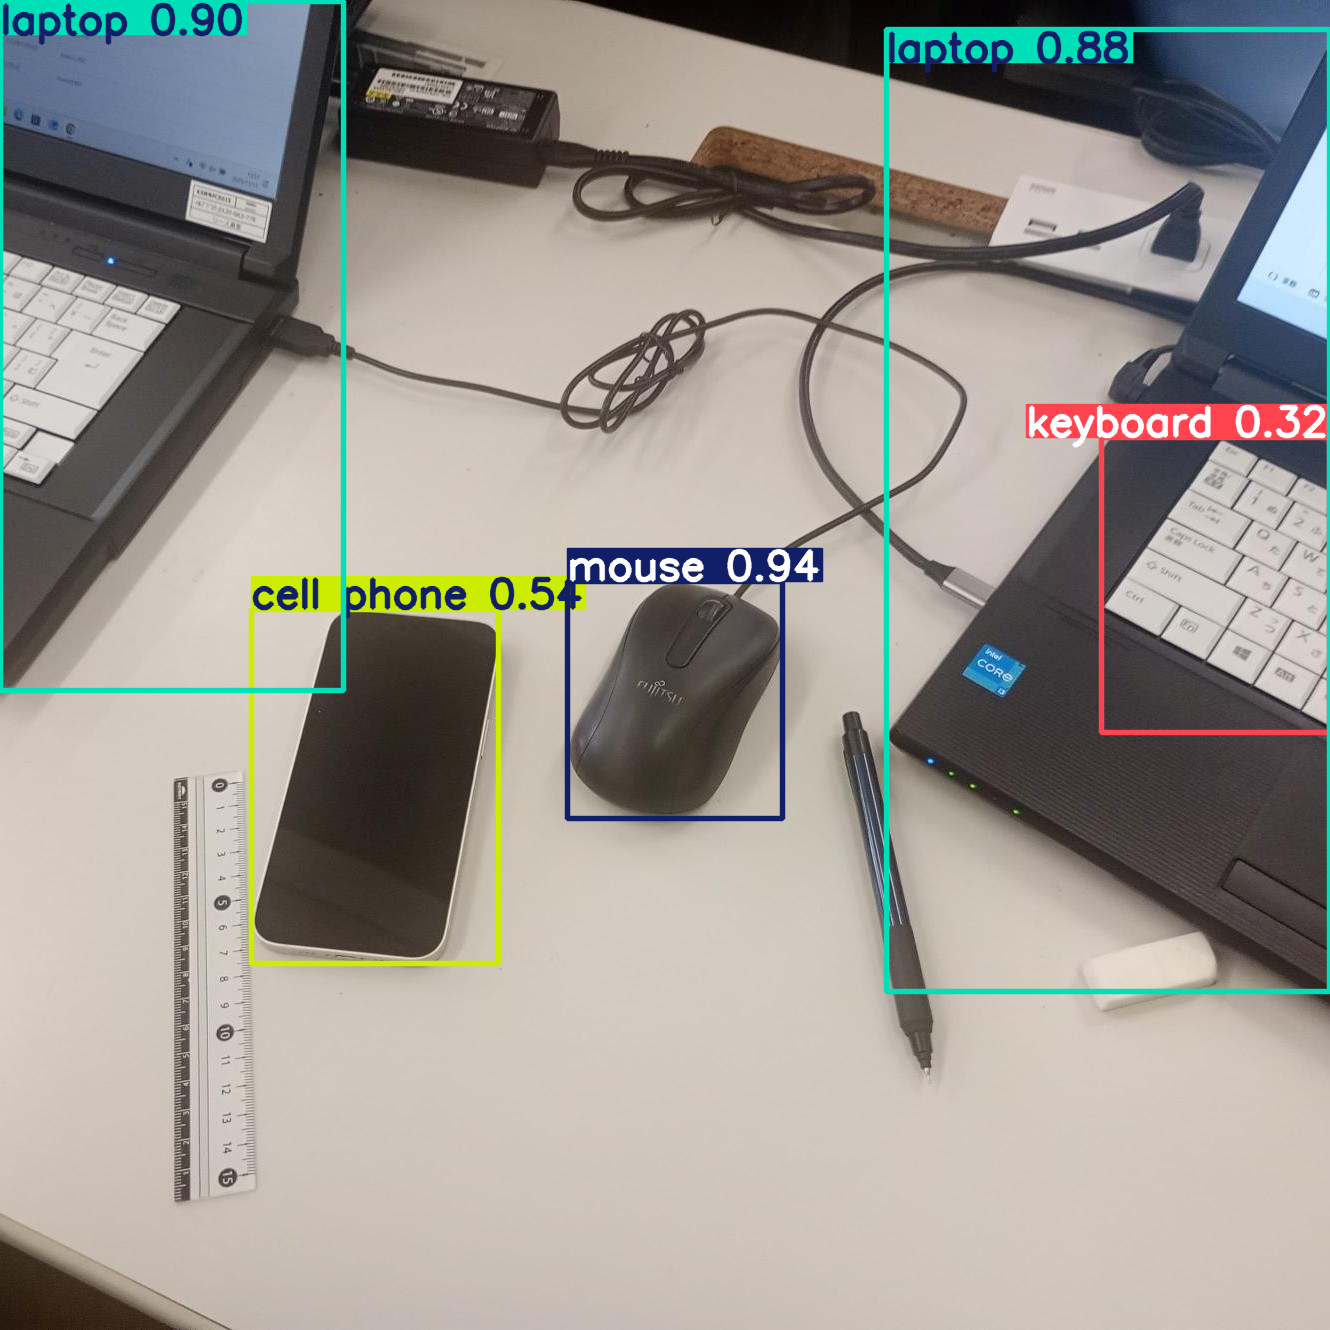

'output.jpg'

In [ ]:
## 突発使用時用

from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow  # 👈 Colab用のimshow

# モデルをロード
model = YOLO('yolov8n.pt')

# 推論したい画像パス
image_path = '/content/メディア (1).jpg'

# 推論を実行
results = model(image_path)

# 結果の可視化
for result in results:
    im = result.plot()  # バウンディングボックス付き画像を生成
    cv2_imshow(im)      # 👈 Colabではこれを使う
    cv2.waitKey(0)      # 不要でもOK（Colabでは反応しない）
    cv2.destroyAllWindows()

# 結果をファイルに保存
results[0].save(filename='output.jpg')



0: 640x512 1 bed, 1 clock, 224.0ms
Speed: 6.5ms preprocess, 224.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 2 potted plants, 1 bed, 2 vases, 202.1ms
Speed: 6.7ms preprocess, 202.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
Class bed object moved: dx=-0.2, dy=14.0


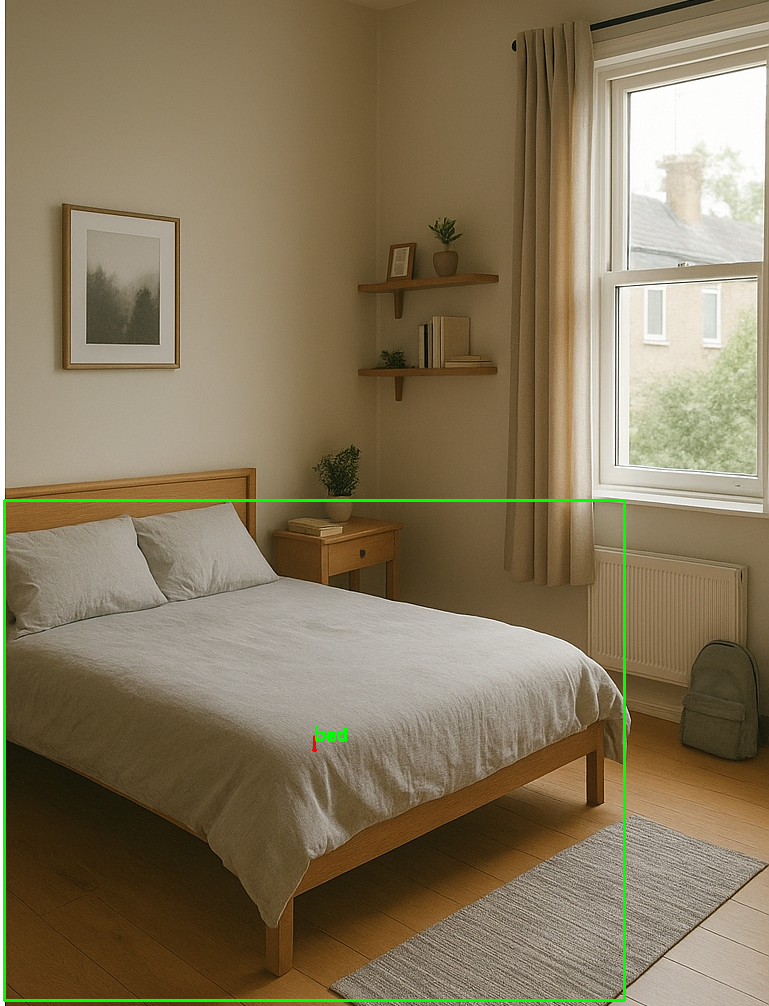

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np
from google.colab.patches import cv2_imshow

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

# 学習済みモデル読み込み
model = YOLO('yolov8n.pt')

# 画像読み込み
img_before = cv2.imread('before.png')
img_after = cv2.imread('after.png')

if img_before is None:
    print("before.png の読み込みに失敗しました。ファイル名やパスを確認してください。")

if img_after is None:
    print("after.png の読み込みに失敗しました。ファイル名やパスを確認してください。")


# 物体検出
results_before = model(img_before)[0]
results_after = model(img_after)[0]

# 変更前の検出結果を辞書にまとめる（クラスごと）
objs_before = {}
for box, cls in zip(results_before.boxes.xyxy.cpu().numpy(), results_before.boxes.cls.cpu().numpy().astype(int)):
    objs_before.setdefault(cls, []).append(box)

# 変更後の検出結果も同様に
objs_after = {}
for box, cls in zip(results_after.boxes.xyxy.cpu().numpy(), results_after.boxes.cls.cpu().numpy().astype(int)):
    objs_after.setdefault(cls, []).append(box)

# マッチング＆移動量計算
for cls in objs_before.keys():
    if cls not in objs_after:
        continue
    before_boxes = objs_before[cls]
    after_boxes = objs_after[cls]

    matched_after = set()

    for i, box_b in enumerate(before_boxes):
        best_iou = 0
        best_j = -1
        for j, box_a in enumerate(after_boxes):
            if j in matched_after:
                continue
            cur_iou = iou(box_b, box_a)
            if cur_iou > best_iou:
                best_iou = cur_iou
                best_j = j
        if best_j >= 0:
            matched_after.add(best_j)

            # 移動量計算（重心の差）
            cx_b = (box_b[0] + box_b[2]) / 2
            cy_b = (box_b[1] + box_b[3]) / 2
            cx_a = (after_boxes[best_j][0] + after_boxes[best_j][2]) / 2
            cy_a = (after_boxes[best_j][1] + after_boxes[best_j][3]) / 2

            dx = cx_a - cx_b
            dy = cy_a - cy_b

            print(f'Class {model.names[cls]} object moved: dx={dx:.1f}, dy={dy:.1f}')

            # 画像に描画
            cv2.rectangle(img_after, (int(after_boxes[best_j][0]), int(after_boxes[best_j][1])),
                          (int(after_boxes[best_j][2]), int(after_boxes[best_j][3])), (0, 255, 0), 2)
            cv2.arrowedLine(img_after, (int(cx_b), int(cy_b)), (int(cx_a), int(cy_a)), (0, 0, 255), 2)
            cv2.putText(img_after, model.names[cls], (int(cx_a), int(cy_a) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

cv2_imshow(img_after)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving after.png to after.png
